In [1]:
import torch
import random

import numpy as np

import matplotlib.pyplot as plt
from torchvision import datasets, transforms

In [2]:
# 1. Load MNIST and convert images to flattened vectors
def load_mnist(flatten=True):
    transform = transforms.Compose([transforms.ToTensor()])
    mnist = datasets.MNIST(root="./data", train=True, download=True, transform=transform)
    data = mnist.data.numpy()
    targets = mnist.targets.numpy()
    
    if flatten:
        data = data.reshape((data.shape[0], -1))  # Flatten 28x28 -> 784
    return data, targets

# 2. Create bags with key instance tracking
def create_bags(data, targets, bag_size=10, num_bags=1000, key_digit=3, key_instances_per_bag=1):
    """
    Create bags for multi-instance learning with controlled number of key digit instances.

    Args:
        data: np.ndarray of shape (N, 784)
        targets: np.ndarray of shape (N,)
        bag_size: number of instances per bag
        num_bags: number of bags to create
        key_digit: which digit is considered the "key"
        key_instances_per_bag: how many key instances should appear in positive bags (set to 0 for negative)
    
    Returns:
        bags: list of np.ndarrays of shape (bag_size, 784)
        bag_labels: list of 0/1
        key_indices: list of lists of positions of key instances
    """
    key_indices_all = np.where(targets == key_digit)[0]
    non_key_indices_all = np.where(targets != key_digit)[0]

    bags = []
    bag_labels = []
    key_indices_per_bag = []

    for _ in range(num_bags):
        is_positive = np.random.rand() < 0.5  # 50% chance for positive bag

        if is_positive:
            # Sample required number of key instances
            key_sample_indices = np.random.choice(key_indices_all, size=key_instances_per_bag, replace=False)

            # Sample remaining from non-key instances
            remaining = bag_size - key_instances_per_bag
            non_key_sample_indices = np.random.choice(non_key_indices_all, size=remaining, replace=False)

            # Combine and shuffle
            full_indices = np.concatenate([key_sample_indices, non_key_sample_indices])
            np.random.shuffle(full_indices)

            # Record key positions
            key_pos_in_bag = [i for i, idx in enumerate(full_indices) if idx in key_sample_indices]
            label = 1

        else:
            # All from non-key digits
            full_indices = np.random.choice(non_key_indices_all, size=bag_size, replace=False)
            key_pos_in_bag = []
            label = 0

        bag = data[full_indices]
        bags.append(bag)
        bag_labels.append(label)
        key_indices_per_bag.append(key_pos_in_bag)

    return bags, bag_labels, key_indices_per_bag

In [3]:
def show_digit(vector, title=None):
    """
    Display a flattened MNIST digit vector (1D array of length 784).
    """
    if vector.shape[0] != 784:
        raise ValueError("Expected a vector of length 784.")
    
    image = vector.reshape(28, 28)
    plt.imshow(image, cmap="gray")
    plt.axis("off")
    if title:
        plt.title(title)
    plt.show()

import matplotlib.pyplot as plt

def visualize_bag_with_weights(bag, weights, title=None, cmap='gray'):
    """
    Visualizes the digits in a bag alongside their predicted weights.

    Args:
        bag: np.ndarray of shape (bag_size, 784) — flattened digit images
        weights: np.ndarray of shape (bag_size,) — model outputs per instance
        title: Optional title for the whole figure
        cmap: Matplotlib colormap
    """
    bag_size = len(bag)
    cols = min(5, bag_size)
    rows = (bag_size + cols - 1) // cols
    
    fig, axes = plt.subplots(rows, cols, figsize=(2.5*cols, 2.5*rows))
    axes = axes.flatten()

    for i in range(bag_size):
        image = bag[i].reshape(28, 28)
        axes[i].imshow(image, cmap=cmap)
        axes[i].set_title(f"{weights[i]:.2f}", fontsize=12)
        axes[i].axis("off")

    for i in range(bag_size, len(axes)):
        axes[i].axis("off")

    if title:
        fig.suptitle(title, fontsize=16)
    plt.tight_layout()
    plt.show()

In [4]:
def compute_kid_accuracy(key_indices, bag_probs, bag_labels):
    """
    Compute key instance detection accuracy from model output probabilities.

    Args:
        bag_probs: List of NumPy arrays of shape (bag_size,) – predicted probabilities per instance
        key_indices: List of lists with ground-truth key positions per bag
        bag_labels: List of bag labels (1 = contains key, 0 = does not)

    Returns:
        Accuracy over positive bags
    """
    predicted_indices = [np.argmax(probs) for probs in bag_probs]
    correct = 0
    total = 0

    for pred_idx, true_keys, label in zip(predicted_indices, key_indices, bag_labels):
        if label == 1:
            total += 1
            if pred_idx in true_keys:
                correct += 1

    return correct / total if total > 0 else 0.0

### 1. Create MNIST dataset

In [5]:
data, targets = load_mnist()
bags, labels, key_pos = create_bags(data, targets, bag_size=10, num_bags=500, key_digit=3, key_instances_per_bag=1)

# Let's inspect a few
for i in range(3):
    print(f"Bag {i} - Label: {labels[i]}, Key digit indices: {key_pos[i]}")

Bag 0 - Label: 0, Key digit indices: []
Bag 1 - Label: 0, Key digit indices: []
Bag 2 - Label: 0, Key digit indices: []


### 2. Key Instance Detection

In [6]:
import pandas as pd

from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

from sklearn.ensemble import RandomForestRegressor

from qsarmil.mil.wrapper import InstanceWrapper, BagWrapper
from qsarmil.mil.network.regressor import InstanceNetworkRegressor, BagNetworkRegressor

from qsarmil.mil.network.classifier import (AttentionNetworkClassifier,
                                            GatedAttentionNetworkClassifier,
                                            SelfAttentionNetworkClassifier,
                                            TempAttentionNetworkClassifier,
                                            GaussianPoolingNetworkClassifier,
                                            DynamicPoolingNetworkClassifier)

from qsarmil.mil.preprocessing import BagMinMaxScaler

In [7]:
network_hparams = {'hidden_layer_sizes':(256, 128, 64),
                   'num_epoch':300,
                   'batch_size':128,
                   'learning_rate':0.001,
                   'weight_decay':0.001,
                   'instance_weight_dropout':0.01,
                   'init_cuda':False,
                   'verbose':False}

In [8]:
x_train, x_test, y_train, y_test, key_train, key_test = train_test_split(bags, labels, key_pos)

In [9]:
scaler = BagMinMaxScaler()

scaler.fit(x_train)

x_train_scaled = scaler.transform(x_train)
x_test_scaled = scaler.transform(x_test)

In [10]:
model = AttentionNetworkClassifier(**network_hparams)
model.fit(x_train_scaled, y_train)

AttentionNetworkClassifier(
  (extractor): Sequential(
    (0): Linear(in_features=784, out_features=256, bias=True)
    (1): ReLU()
    (2): Linear(in_features=256, out_features=128, bias=True)
    (3): ReLU()
    (4): Linear(in_features=128, out_features=64, bias=True)
    (5): ReLU()
  )
  (estimator): Linear(in_features=64, out_features=1, bias=True)
  (attention): Sequential(
    (0): Linear(in_features=64, out_features=64, bias=True)
    (1): Tanh()
    (2): Linear(in_features=64, out_features=1, bias=True)
  )
)

In [11]:
y_prob = model.predict(x_test_scaled)
y_pred = np.where(y_prob > 0.5, 1, 0)
w_pred = model.get_instance_weights(x_test_scaled)

In [12]:
accuracy_score(y_test, y_pred)

0.784

In [14]:
compute_kid_accuracy(key_test, w_pred, y_test)

0.864406779661017

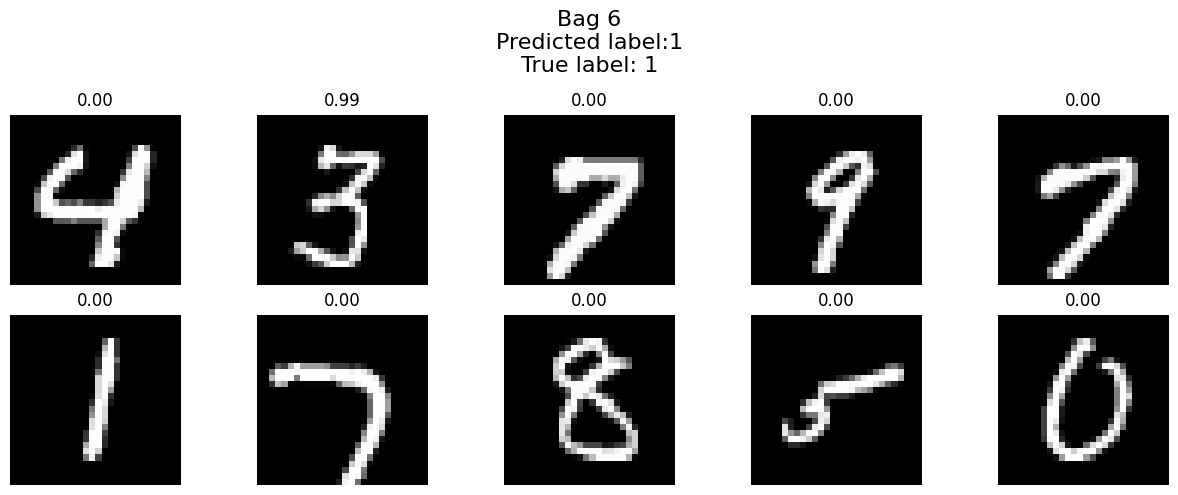

In [15]:
N = 6
visualize_bag_with_weights(x_test[N], w_pred[N], title=f"Bag {N}\nPredicted label:{y_pred[N].item()}\nTrue label: {y_test[N]}")

### 3. KID networks benchmark

In [16]:
network_list = [
                ("AttentionNetworkClassifier", AttentionNetworkClassifier(**network_hparams)), 
                ("GatedAttentionNetworkClassifier", GatedAttentionNetworkClassifier(**network_hparams)), 
                ("SelfAttentionNetworkClassifier", SelfAttentionNetworkClassifier(**network_hparams)), 
                ("TemperatureAttentionNetworkClassifier", TempAttentionNetworkClassifier(**network_hparams)),
                ("GaussianPoolingNetworkClassifier", GaussianPoolingNetworkClassifier(**network_hparams)), 
                ("DynamicPoolingNetworkClassifier", DynamicPoolingNetworkClassifier(**network_hparams))
               ]

In [17]:
res = pd.DataFrame()
for name, model in network_list:
    # train model
    model.fit(x_train_scaled, y_train)
    # predict
    y_prob = model.predict(x_test_scaled)
    y_pred = np.where(y_prob > 0.5, 1, 0)
    w_pred = model.get_instance_weights(x_test_scaled)
    #
    res.loc[name, "PRED_ACC"] = accuracy_score(y_test, y_pred)
    res.loc[name, "KID_ACC"] = compute_kid_accuracy(key_test, w_pred, y_test)

In [18]:
res

,PRED_ACC,KID_ACC
AttentionNetworkClassifier,0.784,0.864407
GatedAttentionNetworkClassifier,0.808,0.830508
SelfAttentionNetworkClassifier,0.808,0.288136
TemperatureAttentionNetworkClassifier,0.776,0.847458
GaussianPoolingNetworkClassifier,0.768,0.152542
DynamicPoolingNetworkClassifier,0.800,0.864407
